In [1]:
!pip install ucimlrepo

In [15]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
# from keras import metrics
from scipy.stats import chi2_contingency

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features
y = mushroom.data.targets

X = X.drop(columns=['odor', 'stalk-root', 'ring-type', 'spore-print-color', 'population', 'habitat'])

# metadata
print(mushroom.metadata)

# variable information
print(mushroom.variables)

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

In [4]:
# Quick overview of dataset

# Check shape
print(X.shape)
print(y.shape)

# View first few rows
X.head()

(8124, 16)
(8124, 1)


,cap-shape,cap-surface,cap-color,bruises,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number
0,x,s,n,t,f,c,n,k,e,s,s,w,w,p,w,o
1,x,s,y,t,f,c,b,k,e,s,s,w,w,p,w,o
2,b,s,w,t,f,c,b,n,e,s,s,w,w,p,w,o
3,x,y,w,t,f,c,n,n,e,s,s,w,w,p,w,o
4,x,s,g,f,f,w,b,k,t,s,s,w,w,p,w,o


In [5]:
X.columns

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'gill-attachment',
       'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
       'stalk-surface-above-ring', 'stalk-surface-below-ring',
       'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type',
       'veil-color', 'ring-number'],
      dtype='object')

In [6]:
# Convert 'y' to a 1D Series
y_series = y.squeeze()

# Verify the conversion
print("Shape of y_series after conversion:", y_series.shape)
print("First few values of y_series:", y_series.head())
print("Unique values in y_series:", y_series.unique())


Shape of y_series after conversion: (8124,)
First few values of y_series: 0    p
1    e
2    e
3    p
4    e
Name: poisonous, dtype: object
Unique values in y_series: ['p' 'e']


In [7]:
# Check for missing values
print(X.isnull().sum())

cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
dtype: int64


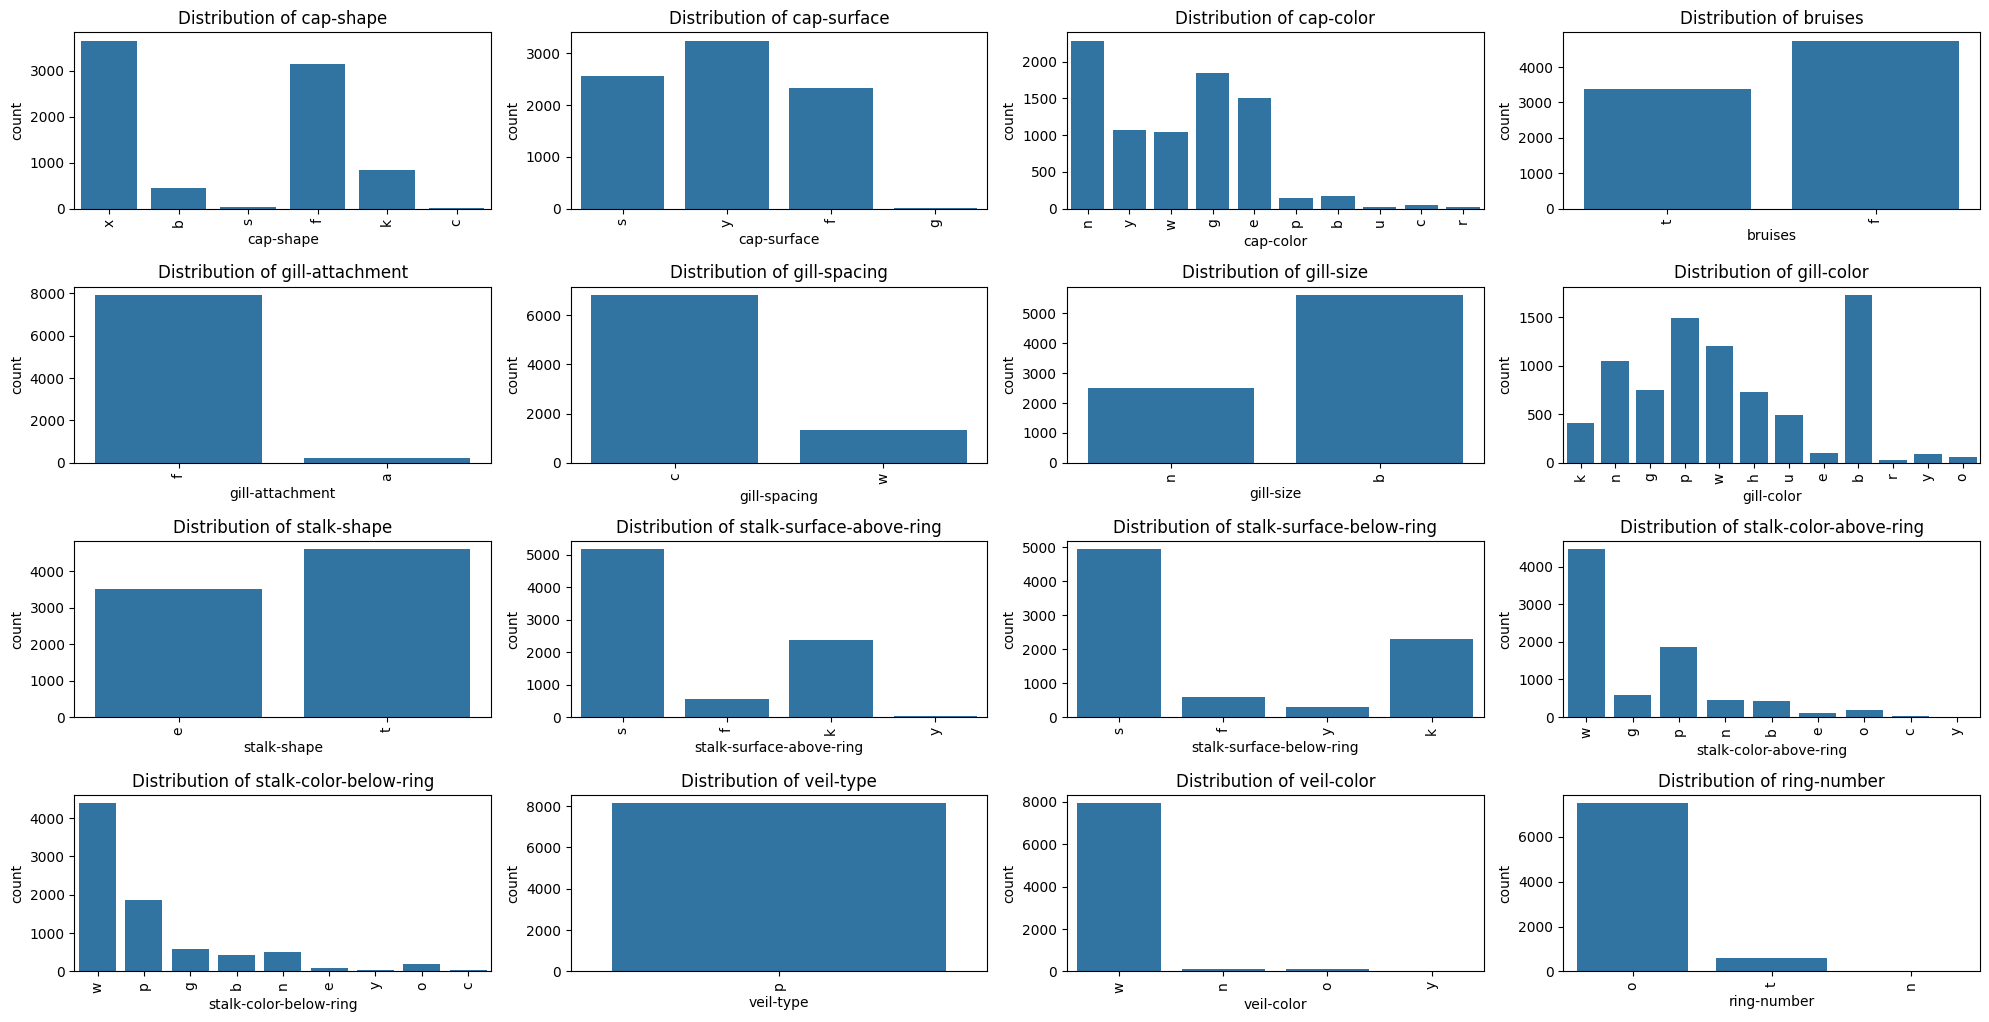

In [8]:
# Number of rows and columns for the grid
n_rows, n_cols = 6, 4

# Create a grid of subplots for feature distributions
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

# Plot each feature's distribution
for i, column in enumerate(X.columns):
    sns.countplot(data=X, x=column, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].tick_params(axis='x', rotation=90)

# Hide remaining empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

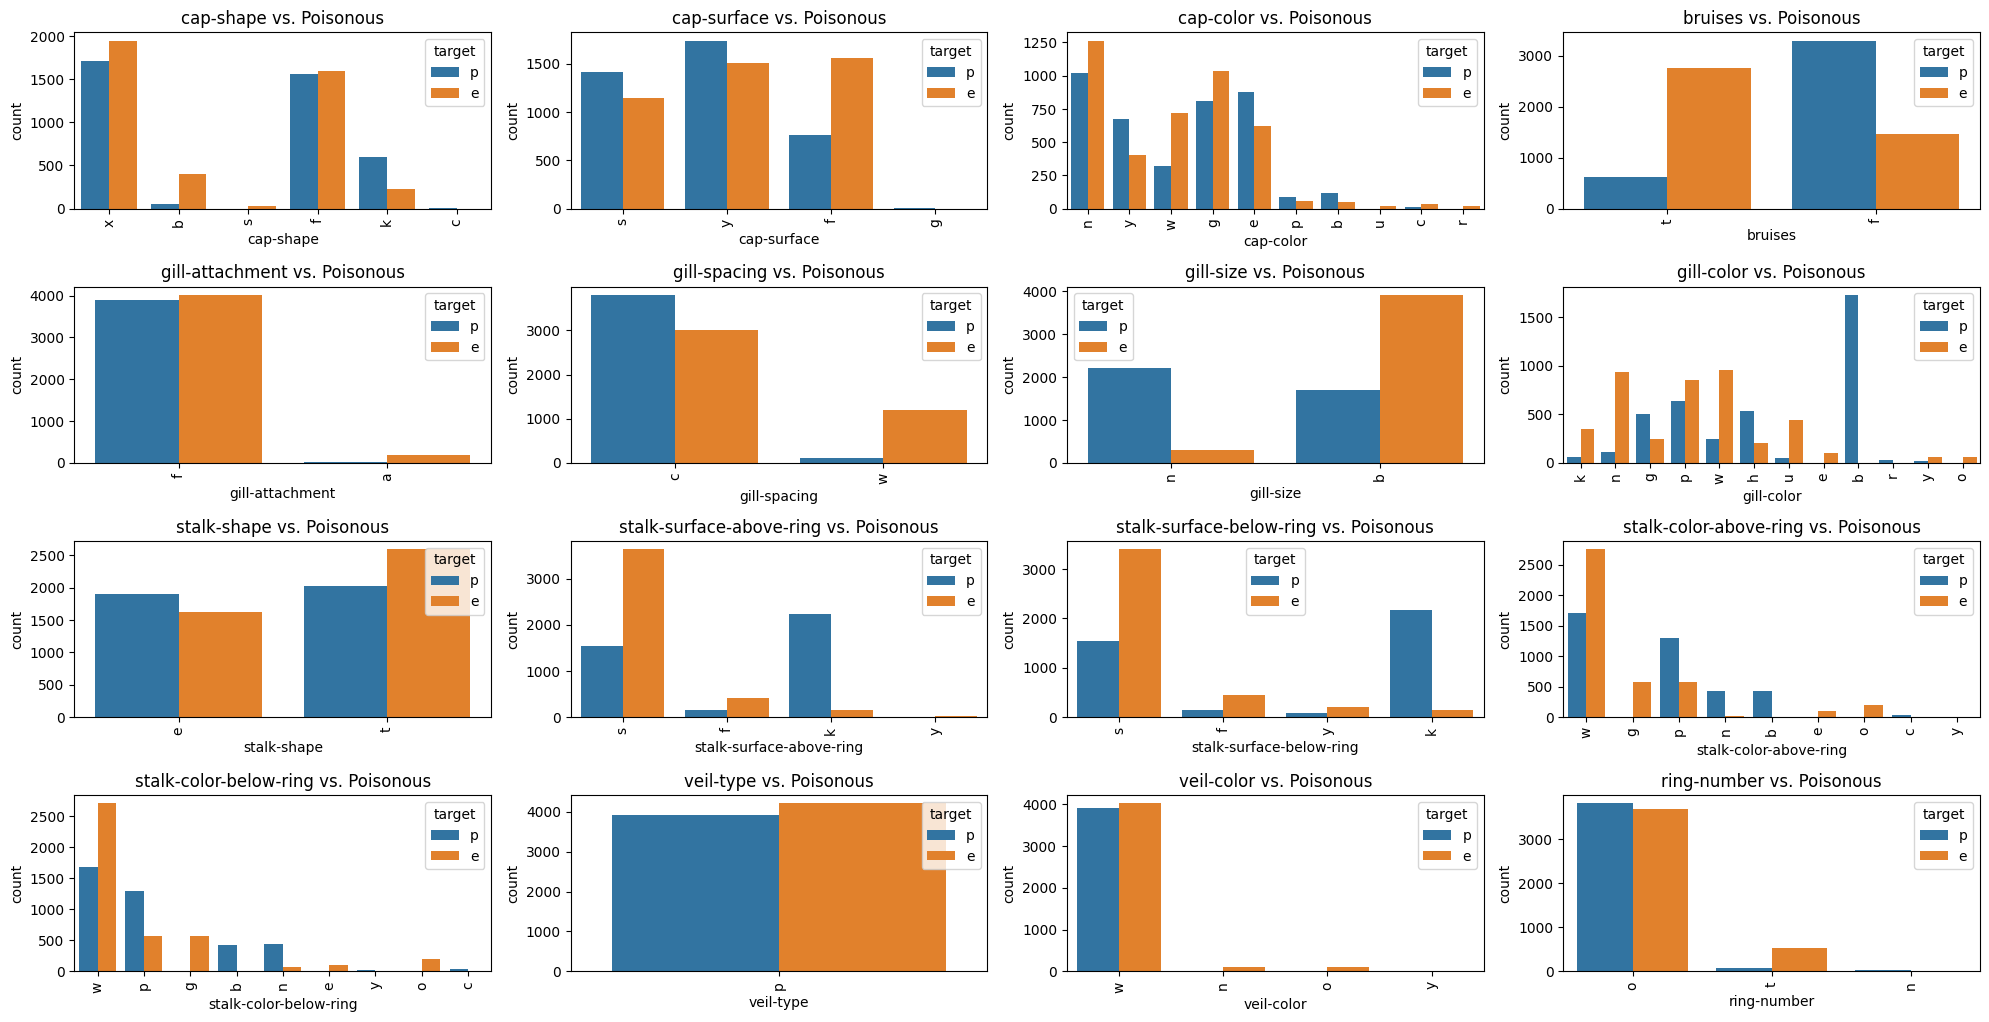

In [9]:
# Add target to the features dataframe temporarily
X['target'] = y_series

# Create a grid of subplots for feature-target relationships
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

# Plot each feature's relationship with the target
for i, column in enumerate(X.columns[:-1]):  # Exclude the 'target' column itself
    sns.countplot(data=X, x=column, hue='target', ax=axes[i])
    axes[i].set_title(f'{column} vs. Poisonous')
    axes[i].tick_params(axis='x', rotation=90)

# Hide remaining empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Remove the target column after plotting
X = X.drop(columns=['target'])

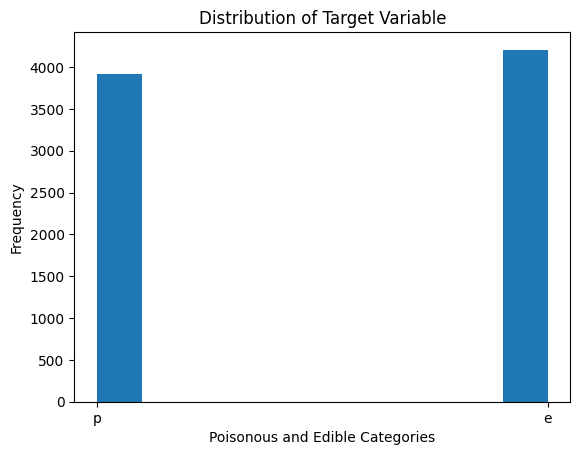

In [10]:
# plot target variable

# Create a grid of subplots for feature distributions
plt.hist(y_series)
plt.title("Distribution of Target Variable")
plt.xlabel("Poisonous and Edible Categories")
plt.ylabel("Frequency")
plt.show()

In [11]:
# Chi-Square analysis for each feature against the target
chi2_results = {}
for column in X.columns:
    contingency_table = pd.crosstab(X[column], y_series)
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_results[column] = p

# Display results
for feature, p_value in chi2_results.items():
    print(f"{feature}: p-value = {p_value:.4f}")

cap-shape: p-value = 0.0000
cap-surface: p-value = 0.0000
cap-color: p-value = 0.0000
bruises: p-value = 0.0000
gill-attachment: p-value = 0.0000
gill-spacing: p-value = 0.0000
gill-size: p-value = 0.0000
gill-color: p-value = 0.0000
stalk-shape: p-value = 0.0000
stalk-surface-above-ring: p-value = 0.0000
stalk-surface-below-ring: p-value = 0.0000
stalk-color-above-ring: p-value = 0.0000
stalk-color-below-ring: p-value = 0.0000
veil-type: p-value = 1.0000
veil-color: p-value = 0.0000
ring-number: p-value = 0.0000


In [12]:
# One-Hot Encoding of categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Encode the target variable (assuming 'p' = poisonous, 'e' = edible)
y_encoded = y_series.apply(lambda x: 1 if x == 'p' else 0)

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)


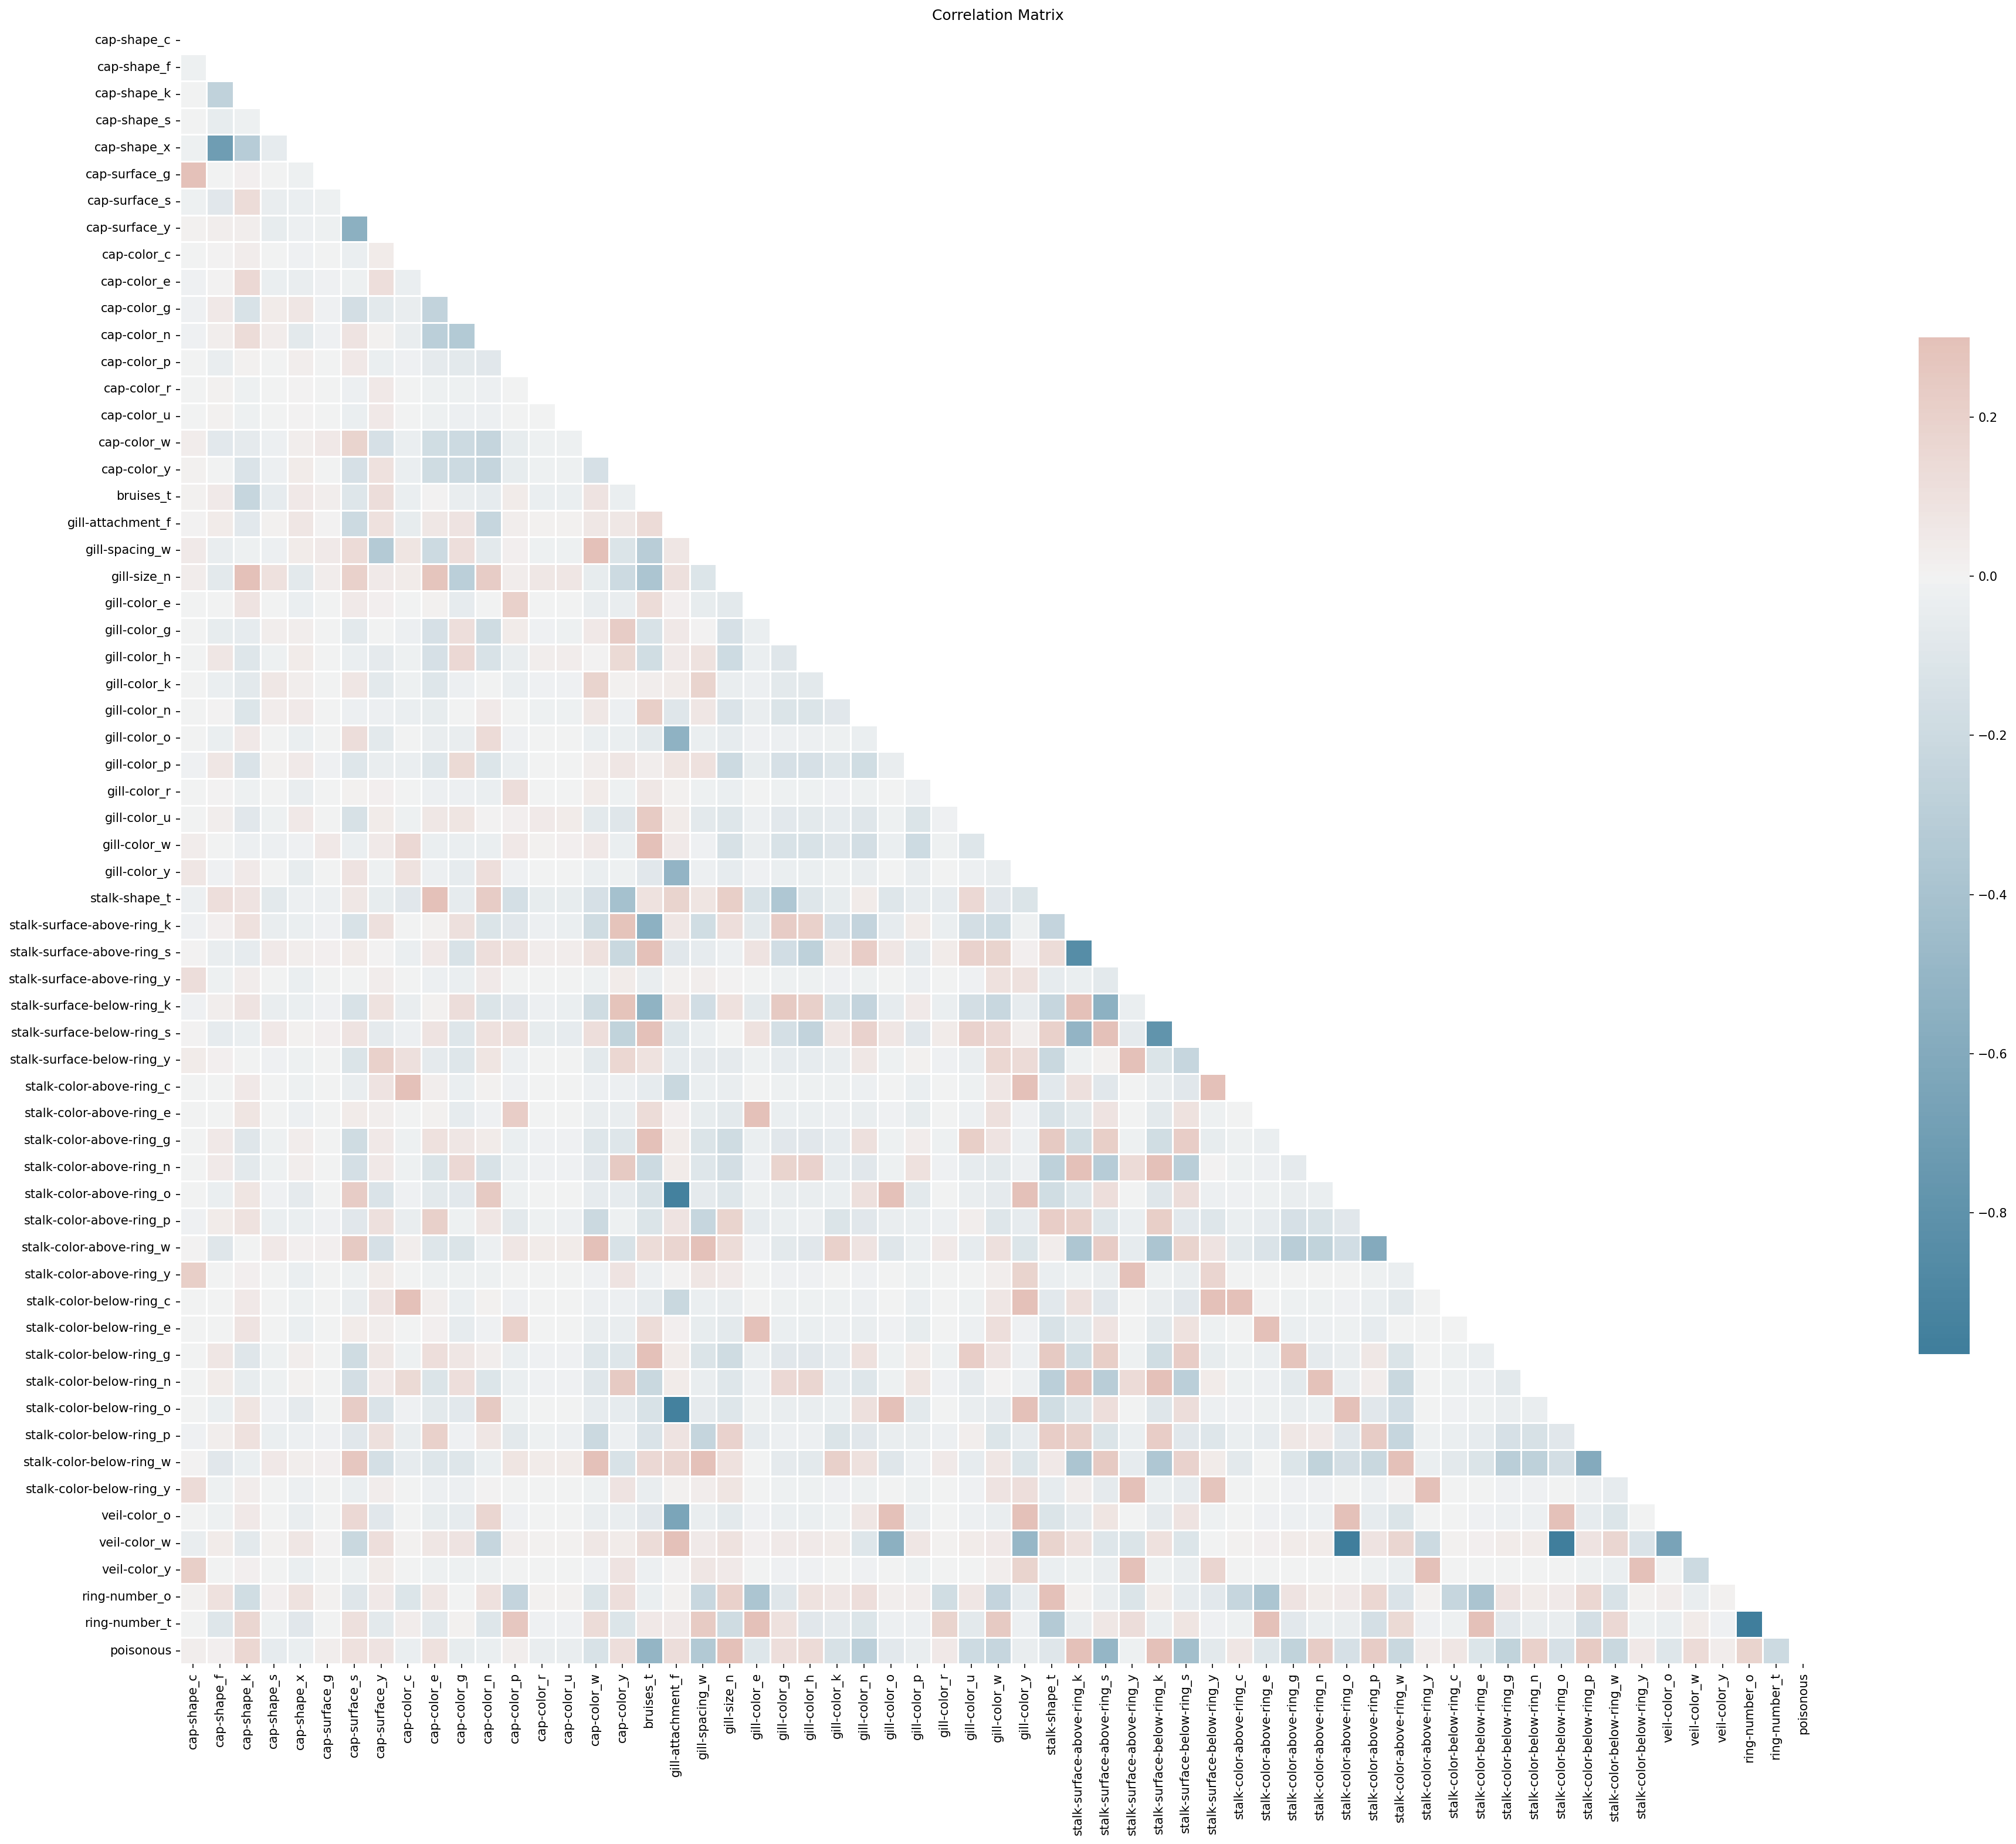

In [14]:
corr = pd.concat([X_train, y_train], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(30, 30), dpi=150)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation Matrix')
plt.show()

Best Hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
Best Score: 0.9687298408670528
Baseline Model - Logistic Regression:
Accuracy: 0.9674
Precision: 0.9596
Recall: 0.9731
F1 Score: 0.9663


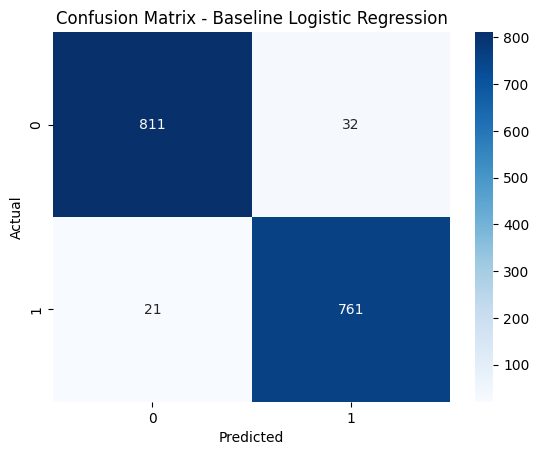

In [21]:
# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=5000, random_state=42)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)

# Best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

baseline_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = baseline_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Baseline Model - Logistic Regression:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Baseline Logistic Regression")
plt.show()

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.9961712297007403
Baseline Model - Logistic Regression:
Accuracy: 0.9957
Precision: 0.9936
Recall: 0.9974
F1 Score: 0.9955


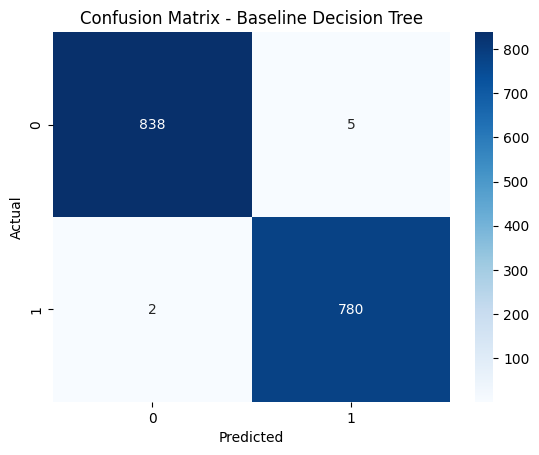

In [22]:
# prompt: generate a decision tree baseline_model_2 which fits X_train and Y_train

from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree model
model = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(model, param_grid, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)

# Best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

baseline_model_2 = grid_search.best_estimator_

# Make predictions on the test set
y_pred_2 = baseline_model_2.predict(X_test)

# Evaluate the model
accuracy_2 = accuracy_score(y_test, y_pred_2)
precision_2 = precision_score(y_test, y_pred_2)
recall_2 = recall_score(y_test, y_pred_2)
f1_2 = f1_score(y_test, y_pred_2)

print(f"Baseline Model - Logistic Regression:")
print(f"Accuracy: {accuracy_2:.4f}")
print(f"Precision: {precision_2:.4f}")
print(f"Recall: {recall_2:.4f}")
print(f"F1 Score: {f1_2:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Baseline Decision Tree")
plt.show()